In [12]:
import requests
import time
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

## Time to gather BTC Daily Historical Data

In [5]:
def fetch_bitget_funding_rates(symbol, product_type, start_date, end_date):
    """
    Fetch historical funding rates from Bitget API for a given symbol and date range.

    Parameters:
        symbol (str): Trading pair (e.g., "BTCUSDT").
        product_type (str): Product type (e.g., "USDT-FUTURES").
        start_date (str): Start date in "YYYY-MM-DD" format.
        end_date (str): End date in "YYYY-MM-DD" format.

    Returns:
        pd.DataFrame: A DataFrame containing funding rates and timestamps.
    """
    url = "https://api.bitget.com/api/v2/mix/market/history-fund-rate"
    page_size = 100  # Maximum allowed page size
    page_no = 1
    all_data = []

    while True:
        params = {
            "symbol": symbol,
            "productType": product_type,
            "pageSize": page_size,
            "pageNo": page_no,
        }

        response = requests.get(url, params=params)

        if response.status_code != 200:
            print(f"Error: {response.status_code}, {response.text}")
            break

        data = response.json()

        if data["code"] != "00000":
            print(f"API Error: {data['msg']}")
            break

        entries = data["data"]
        if not entries:
            break

        all_data.extend(entries)

        # Increment page number for pagination
        page_no += 1

        # Add delay to avoid hitting rate limits
        time.sleep(1)

    # Convert to DataFrame
    df = pd.DataFrame(all_data)

    # Convert fundingTime from milliseconds to readable datetime
    df["fundingTime"] = pd.to_datetime(df["fundingTime"].astype(int), unit="ms")

    # Filter by date range
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    df = df[(df["fundingTime"] >= start_date) & (df["fundingTime"] <= end_date)]

    # Convert fundingRate to float for numerical operations
    df["fundingRate"] = df["fundingRate"].astype(float)

    return df

# Example usage
symbol = "BTCUSDT"
product_type = "USDT-FUTURES"
start_date = "2022-01-01"
end_date = "2024-12-31"

funding_rates_df = fetch_bitget_funding_rates(symbol, product_type, start_date, end_date)

# Print first few rows to verify the data
print(funding_rates_df.head())

      symbol  fundingRate         fundingTime
144  BTCUSDT     0.000115 2024-12-31 00:00:00
145  BTCUSDT     0.000115 2024-12-30 16:00:00
146  BTCUSDT     0.000110 2024-12-30 08:00:00
147  BTCUSDT    -0.000002 2024-12-30 00:00:00
148  BTCUSDT     0.000126 2024-12-29 16:00:00


In [6]:
def fetch_cryptocompare_historical_data(start_date, end_date, symbol='BTC', currency='USD'):
    """
    Fetches historical daily data from CryptoCompare for a given date range.

    Args:
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        symbol (str): Cryptocurrency symbol (e.g., 'BTC').
        currency (str): Currency to convert to (e.g., 'USD').

    Returns:
        pandas.DataFrame: DataFrame containing the historical data, or None if an error occurs.
    """
    base_url = "https://min-api.cryptocompare.com/data/v2/histoday"
    toTs = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp())
    limit = int((datetime.strptime(end_date, '%Y-%m-%d') - datetime.strptime(start_date, '%Y-%m-%d')).days)
    params = {
        'fsym': symbol,
        'tsym': currency,
        'limit': limit,
        'toTs': toTs,
        'api_key': "YOUR_API_KEY"
    }

    response = requests.get(base_url, params=params)
    response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
    data = response.json()
    if data['Response'] == 'Success':
      df = pd.DataFrame(data['Data']['Data'])  # Access the 'Data' list within the 'Data' dictionary
      df['time'] = pd.to_datetime(df['time'], unit='s')  # Convert timestamp to datetime
      df.set_index('time', inplace=True) # Set timestamp to index
      return df


# Example Usage
start_date = '2022-01-01'
end_date = '2024-12-31'
btc_data = fetch_cryptocompare_historical_data(start_date, end_date)

print("BTC Data Sample:\n", btc_data.head())


print("BTC Data Sample:\n", btc_data.tail())

BTC Data Sample:
                 high       low      open  volumefrom      volumeto     close  \
time                                                                           
2022-01-01  47950.29  46196.03  46197.31    16697.92  7.867300e+08  47737.35   
2022-01-02  47979.26  46666.18  47737.35    13025.66  6.154534e+08  47306.41   
2022-01-03  47572.23  45707.55  47306.41    21681.38  1.011310e+09  46450.79   
2022-01-04  47529.48  45587.91  46450.79    29035.93  1.349229e+09  45824.54   
2022-01-05  47067.18  42510.86  45824.54    47769.20  2.152187e+09  43432.51   

           conversionType conversionSymbol  
time                                        
2022-01-01         direct                   
2022-01-02         direct                   
2022-01-03         direct                   
2022-01-04         direct                   
2022-01-05         direct                   
BTC Data Sample:
                 high       low      open  volumefrom      volumeto     close  \
time    

In [15]:
def fetch_bitcoin_cost_per_transaction(api_key, start_date, end_date):
    """
    Fetch Bitcoin Cost Per Transaction (CPTRA) data from Nasdaq Data Link API.

    Parameters:
      api_key (str): Your Nasdaq Data Link API key.
      start_date (str): Start date in "YYYY-MM-DD" format.
      end_date (str): End date in "YYYY-MM-DD" format.

    Returns:
      pd.DataFrame: A DataFrame containing the requested data.
    """
    url = f"https://data.nasdaq.com/api/v3/datatables/QDL/BCHAIN"

    start = datetime.strptime(start_date, "%Y-%m-%d").date()
    end = datetime.strptime(end_date, "%Y-%m-%d").date()

    current_day = start
    data = []

    while current_day <= end:
        date_str = current_day.strftime("%Y-%m-%d")
        params = {
            "code": "CPTRA",
            "date": date_str,
            "api_key": api_key,
        }

        response = requests.get(url, params=params)
        json_data = response.json()

        if "datatable" in json_data and "data" in json_data["datatable"] and json_data["datatable"]["data"]:
            day_data = json_data["datatable"]["data"][0]
            data.append(day_data)
        else:
            data.append(["CPTRA", date_str, None])
            print(f"Fetched data for {date_str}: {data[-1]}")

        current_day += timedelta(days=1)


    return data

btc_transaction_data = fetch_bitcoin_cost_per_transaction("y6xWnCB1RUMPKyVndvCz", "2022-01-01", "2024-12-31")

Fetched data for 2023-12-24: ['CPTRA', '2023-12-24', None]
Fetched data for 2024-02-16: ['CPTRA', '2024-02-16', None]
Fetched data for 2024-02-17: ['CPTRA', '2024-02-17', None]
Fetched data for 2024-03-30: ['CPTRA', '2024-03-30', None]
Fetched data for 2024-05-05: ['CPTRA', '2024-05-05', None]
Fetched data for 2024-05-18: ['CPTRA', '2024-05-18', None]
Fetched data for 2024-06-01: ['CPTRA', '2024-06-01', None]
Fetched data for 2024-06-13: ['CPTRA', '2024-06-13', None]
Fetched data for 2024-06-14: ['CPTRA', '2024-06-14', None]
Fetched data for 2024-06-15: ['CPTRA', '2024-06-15', None]
Fetched data for 2024-06-16: ['CPTRA', '2024-06-16', None]
Fetched data for 2024-06-17: ['CPTRA', '2024-06-17', None]
Fetched data for 2024-06-18: ['CPTRA', '2024-06-18', None]
Fetched data for 2024-12-03: ['CPTRA', '2024-12-03', None]
Fetched data for 2024-12-04: ['CPTRA', '2024-12-04', None]
Fetched data for 2024-12-05: ['CPTRA', '2024-12-05', None]
Fetched data for 2024-12-06: ['CPTRA', '2024-12-06', Non

## Process Data
### Now that we have gathered the data, we need to process it to make sure it works properly and then split it up correctly between a train and test

In [17]:
#Process Data Now
btc_price_df = pd.DataFrame(btc_data)

btc_price_df.reset_index(inplace=True)
btc_price_df.drop(columns=['time', 'conversionType', 'conversionSymbol', 'volumefrom', 'volumeto'], inplace=True)
btc_price_df.dropna(inplace = True)

funding_rates_df.reset_index(inplace=True)
funding_rates_df['fundingTime'] = pd.to_datetime(funding_rates_df['fundingTime'])
funding_rates_df.set_index('fundingTime', inplace=True)


funding_rate_data_cleaned = funding_rates_df.dropna()

daily_funding_rates = funding_rate_data_cleaned.resample('D').first()
daily_funding_rates.reset_index(inplace=True)

btc_transaction_df = pd.DataFrame(btc_transaction_data)
btc_transaction_df.columns = ['Code', 'Date', 'Fee']
btc_transaction_df.drop(columns=['Code', 'Date'], inplace=True)
btc_transaction_df['Fee'] = btc_transaction_df['Fee'].astype(float)
btc_transaction_df['Fee'] = btc_transaction_df['Fee'].fillna(200)

# Reset indices to ensure positional alignment
btc_price_df = btc_price_df.reset_index(drop=True)
btc_transaction_df = btc_transaction_df.reset_index(drop=True)
daily_funding_rates = daily_funding_rates.reset_index(drop=True)


print(daily_funding_rates.tail())
print(btc_price_df.tail())
print(btc_transaction_df.tail())

     fundingTime  index   symbol  fundingRate
1091  2024-12-27    156  BTCUSDT     0.000123
1092  2024-12-28    153  BTCUSDT     0.000120
1093  2024-12-29    150  BTCUSDT     0.000105
1094  2024-12-30    147  BTCUSDT    -0.000002
1095  2024-12-31    144  BTCUSDT     0.000115
          high       low      open     close
1091  97351.17  93270.34  95680.19  94170.09
1092  95542.25  94008.53  94170.09  95140.15
1093  95175.67  92850.44  95140.15  93564.85
1094  94910.24  91310.52  93564.85  92646.21
1095  96139.70  91894.97  92646.21  93391.98
           Fee
1091  138.3895
1092  144.7204
1093  113.3130
1094  125.6429
1095  122.8493


In [19]:
train_length = int(len(btc_price_df) * 0.8)
btc_price_train_data = btc_price_df[:train_length]
btc_price_test_data = btc_price_df[train_length:]
btc_price_test_data.reset_index(inplace=True)
biden_btc_price_test_data = btc_price_test_data[:163]
trump_btc_price_test_data = btc_price_test_data[163:]
trump_btc_price_test_data.reset_index(inplace=True)

btc_transaction_train_data = btc_transaction_df[:train_length]
btc_transaction_test_data = btc_transaction_df[train_length:]
btc_transaction_test_data.reset_index(inplace=True)
biden_btc_transaction_test_data = btc_transaction_test_data[:163]
trump_btc_transaction_test_data = btc_transaction_test_data[163:]
trump_btc_transaction_test_data.reset_index(inplace=True)


daily_funding_rates_train_data = daily_funding_rates[:train_length]
daily_funding_rates_test_data = daily_funding_rates[train_length:]
daily_funding_rates_test_data.reset_index(inplace=True)
biden_daily_funding_rates_test_data = daily_funding_rates_test_data[:163]
trump_daily_funding_rates_test_data = daily_funding_rates_test_data[163:]
trump_daily_funding_rates_test_data.reset_index(drop=True, inplace=True)



trump_daily_funding_rates_test_data.head()

,level_0,fundingTime,index,symbol,fundingRate
0,1039,2024-11-05,312,BTCUSDT,0.000125
1,1040,2024-11-06,309,BTCUSDT,0.000121
2,1041,2024-11-07,306,BTCUSDT,0.000120
3,1042,2024-11-08,303,BTCUSDT,0.000127
4,1043,2024-11-09,300,BTCUSDT,0.000117


## Intiution
### Bitcoin seem to go up a lot, but there's a lot of directional risk we take to hold on to it. Additionally, bitcoin can very easily move out of a its "normal" range in both directions. This would make it very risky to invest in. Lets see the risk and return of simply holding and selling a Bitcoin at the start and end of day.

# Stratergy
### Our strategy predicates on the thesis that BTC — under “normal conditions” — will usually go up by some point in the future. Because the aforementioned fact is not really too risky (unlike the value of BTC itself), our strategy should be less risky than BTC. Thus, we need to optimize our algorithm to figure out what the optimal entrance conditions are, AKA what “normal conditions” are. Furthermore, we might also want to enter if BTC is outperforming its past returns on a bit to capture any short-term momentum that might be occurring. Finally, we need to optimize our exit. It makes sense that we exit after we make a bit of profit (AKA leave our range of normalcy from above). We should also exit as a stopgap to mitigate losses if BTC plummets however. This number should not, however, be when we fall out of our “normal range” from below as we can hold the perp future perpetually, so we might be missing out on future gains if (when) BTC rebounds. This number should exist, however, as we do want to cap our losses at some point. 


In [21]:
copy_btc_price_df = btc_price_df.copy()
copy_btc_transaction_df = btc_transaction_df.copy()
copy_daily_funding_rates = daily_funding_rates.copy()

list_daily_returns = btc_price_df['open'] - btc_price_df['close'] - 2 * btc_transaction_df['Fee'] - daily_funding_rates['fundingRate'] * 3
list_daily_returns = list_daily_returns.dropna()

mean_return = sum(list_daily_returns) / len(list_daily_returns)
total_returns = sum(list_daily_returns)
standardDev = np.std(list_daily_returns)

print(f"Mean Return: {mean_return}")
print(f"Total Returns: {total_returns}")
print(f"Standard Deviation: {standardDev}")

Mean Return: -220.79511429320254
Total Returns: -241991.44526535
Standard Deviation: 1282.0021119632802


### Lets Backtest our intuition now

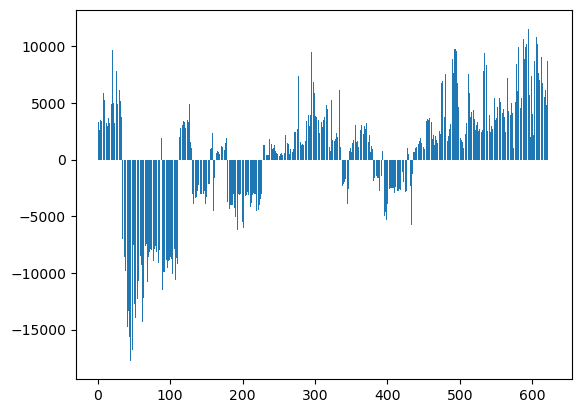

Sharpe Ratio: 0.04978477291803071
Mean Return: 0.17095511800639138
Standard Deviation: 2.8675046069841823
Total Returns: 194320.11807240814
Portfolio Return Rate: 0.18275806570011444


In [23]:
open_positions = {}
profit_log = []
day = 10

def PnL(executionPrice, price, fundingRate, current_day, days):
  total_fr = 3 * fundingRate * days
  entry_fee = btc_transaction_train_data['Fee'].iloc[current_day - days]
  exit_fee = btc_transaction_train_data['Fee'].iloc[current_day]
  profit_log.append(((price/20 + entry_fee + exit_fee + total_fr), (executionPrice - price) - total_fr - entry_fee - exit_fee))

#Main Backtest Logic
for i in range(9, len(btc_price_train_data)):

  past10 = btc_price_train_data['open'].rolling(window=10)
  SMA10 = past10.mean()
  sd = past10.std()
  upper_band = SMA10 + 5 * sd
  lower_band = SMA10 - sd
  current_price = btc_price_train_data['open'].iloc[i]

  if (lower_band.iloc[i] <= current_price) & (current_price <= upper_band.iloc[i]):
    key = (lower_band.iloc[i], upper_band.iloc[i])
    if key not in open_positions:
      open_positions[key] = []
    open_positions[key].append((btc_price_train_data['open'][i], i))

  #Close the positions based on closing prices
  for key, positions in open_positions.items():
    lb, ub = key

    if btc_price_train_data['high'][i] >= ub:
      for position, day in positions:
        PnL(ub, position, daily_funding_rates_train_data['fundingRate'].iloc[day], i, i - day)
      open_positions[key] = [] #Clearing out all positions assosicated with this band (Neal)

    elif btc_price_train_data['low'][i] < lb - 8 * sd.iloc[i]:
      for position, day in positions:
        PnL(lb - 8 * sd.iloc[i], position, daily_funding_rates_train_data['fundingRate'].iloc[day], i, i - day)
      open_positions[key] = [] #Clearing out all positions assosicated with this band (Neal)


  def metrics(profit_log):
    """Calculate performance metrics"""
    if not profit_log:
      return 0, 0, 0

    list_risked = [profit[0] for profit in profit_log]
    list_returns = [profit[1] for profit in profit_log]
    list_of_return_rate = [profit[1]/profit[0] for profit in profit_log]

    mean_rate = sum(list_of_return_rate) / len(list_of_return_rate)
    total_risked = sum(list_risked)
    total_returns = sum(list_returns)
    portfolio_return_rate = total_returns / total_risked
    standardDev = np.std(list_of_return_rate)
    sharpe = (portfolio_return_rate - 0.04) / standardDev

    catergories = [i + 1 for i in range(len(list_returns))]
    plt.bar(catergories, list_returns)
    plt.show()

    return sharpe, mean_rate, standardDev, total_returns, portfolio_return_rate


sharpe, mean_return, std_return, total_returns , portfolio_return_rate = metrics(profit_log)
print(f"Sharpe Ratio: {sharpe}")
print(f"Mean Return: {mean_return}")
print(f"Standard Deviation: {std_return}")
print(f"Total Returns: {total_returns}")
print(f"Portfolio Return Rate: {portfolio_return_rate}")

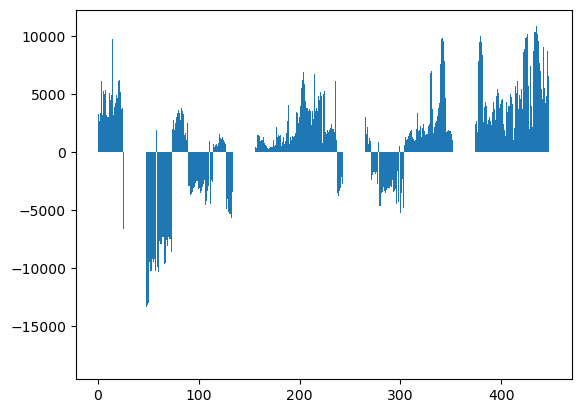

Upper Band SD: 5
Stop Gap Band: 10
Portfolio Return Rate: 0.26435928083335736
Sharpe Ratio: 0.084988232419241


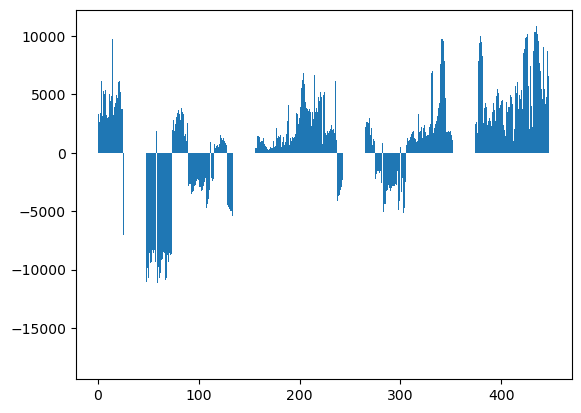

Upper Band SD: 5
Stop Gap Band: 9
Portfolio Return Rate: 0.25886453505174534
Sharpe Ratio: 0.0823863191418737


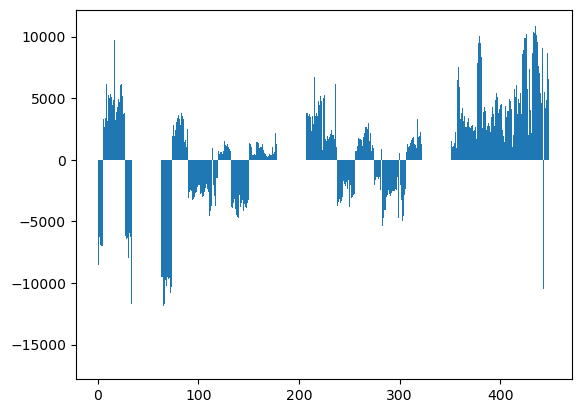

Upper Band SD: 5
Stop Gap Band: 8
Portfolio Return Rate: 0.2593733187491735
Sharpe Ratio: 0.08412410402407318


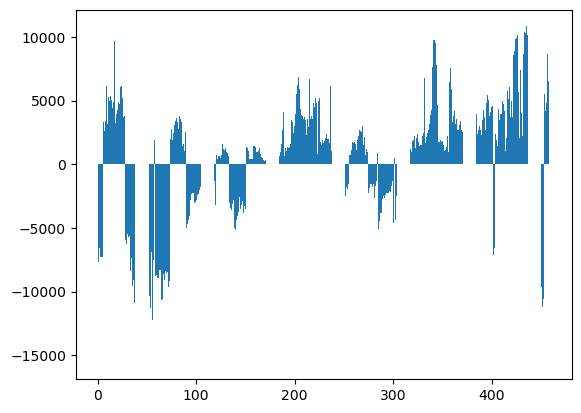

Upper Band SD: 5
Stop Gap Band: 7
Portfolio Return Rate: 0.0866529159680885
Sharpe Ratio: 0.018099110941959866


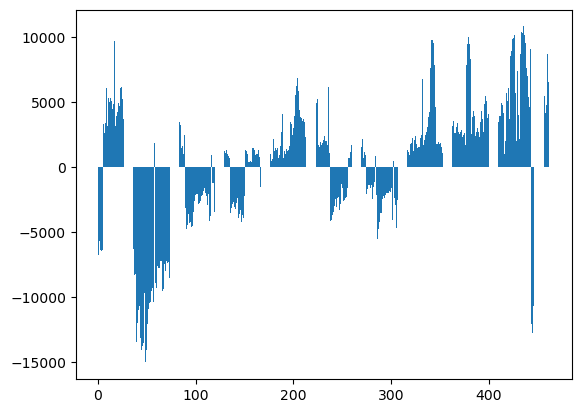

Upper Band SD: 5
Stop Gap Band: 6
Portfolio Return Rate: 0.07512156430158341
Sharpe Ratio: 0.014050526251951688


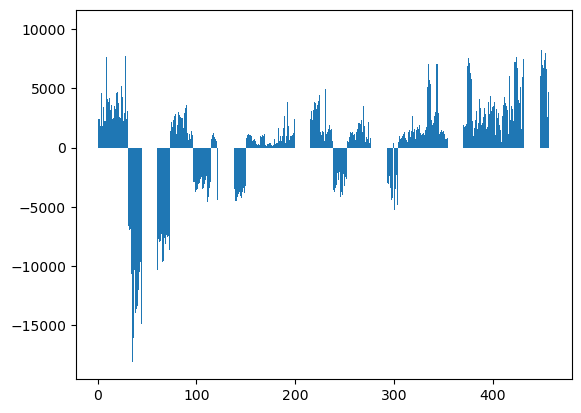

Upper Band SD: 4
Stop Gap Band: 10
Portfolio Return Rate: 0.2181134383133503
Sharpe Ratio: 0.07903057378747169


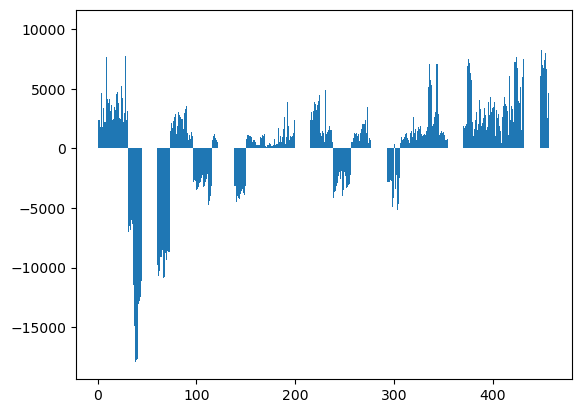

Upper Band SD: 4
Stop Gap Band: 9
Portfolio Return Rate: 0.20744874619392542
Sharpe Ratio: 0.07384875323274047


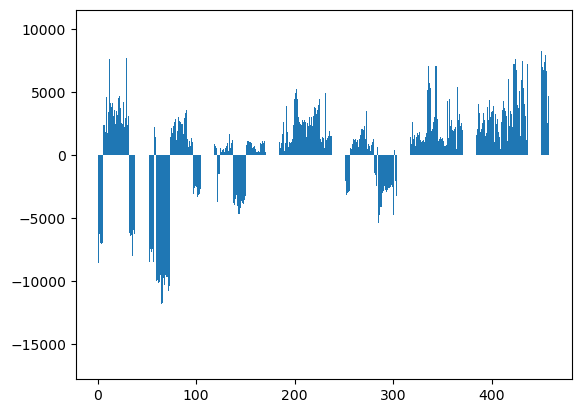

Upper Band SD: 4
Stop Gap Band: 8
Portfolio Return Rate: 0.18598217823850066
Sharpe Ratio: 0.06538124750264135


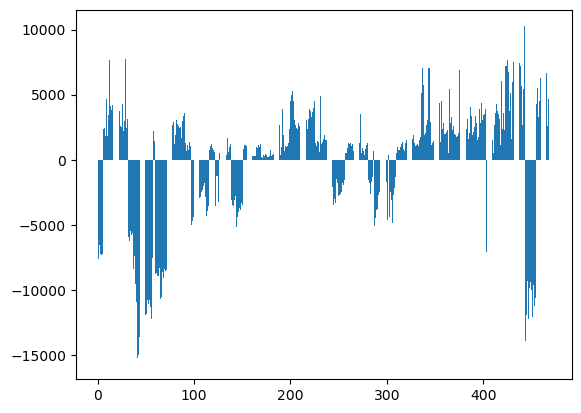

Upper Band SD: 4
Stop Gap Band: 7
Portfolio Return Rate: 0.016027275253031263
Sharpe Ratio: -0.010733309166963759


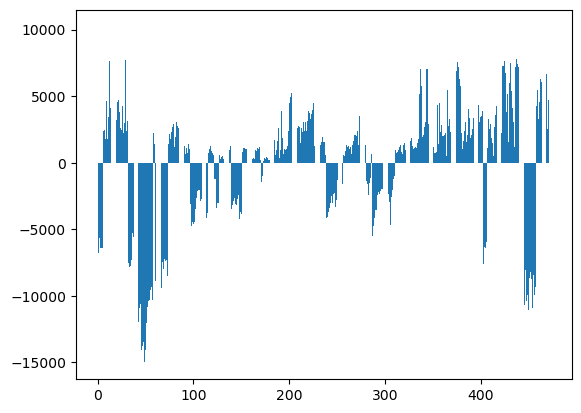

Upper Band SD: 4
Stop Gap Band: 6
Portfolio Return Rate: 0.01463024872587843
Sharpe Ratio: -0.011822072760537787


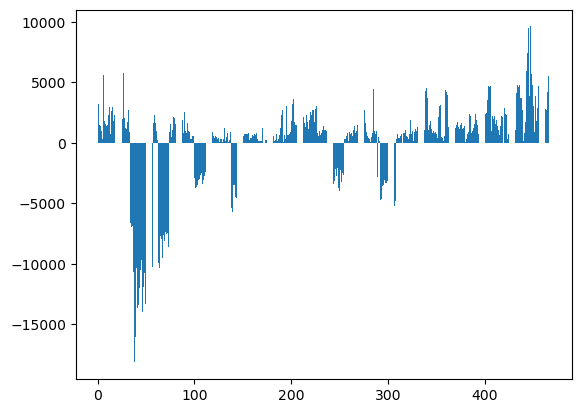

Upper Band SD: 3
Stop Gap Band: 10
Portfolio Return Rate: 0.061564678435084286
Sharpe Ratio: 0.011551554622525342


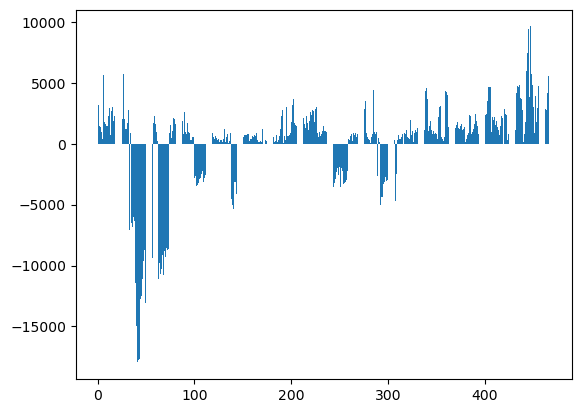

Upper Band SD: 3
Stop Gap Band: 9
Portfolio Return Rate: 0.05141306338845008
Sharpe Ratio: 0.006092717450565223


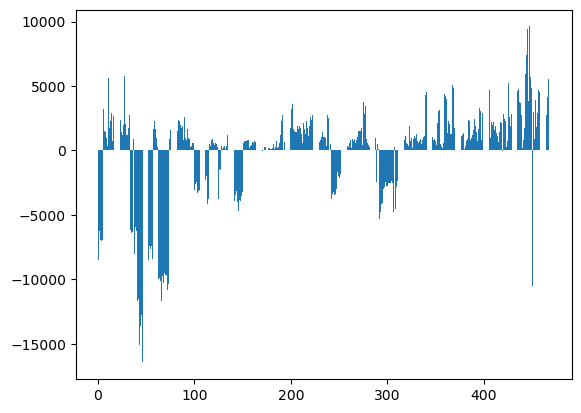

Upper Band SD: 3
Stop Gap Band: 8
Portfolio Return Rate: 0.03321112789829806
Sharpe Ratio: -0.003699722457461493


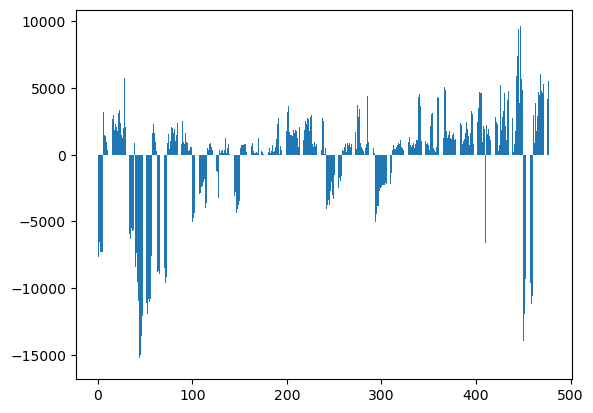

Upper Band SD: 3
Stop Gap Band: 7
Portfolio Return Rate: -0.10492402780409771
Sharpe Ratio: -0.07813523618039309


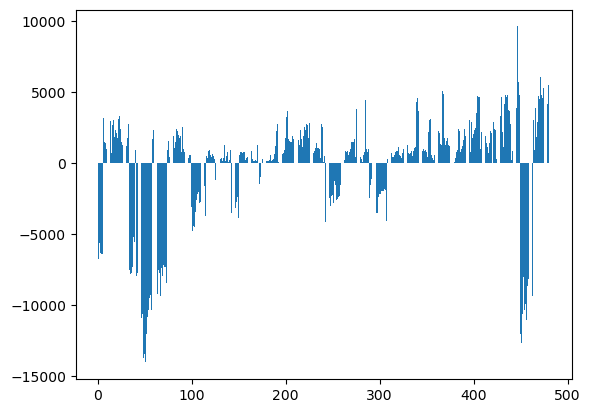

Upper Band SD: 3
Stop Gap Band: 6
Portfolio Return Rate: -0.0834786594951004
Sharpe Ratio: -0.07043337940475825


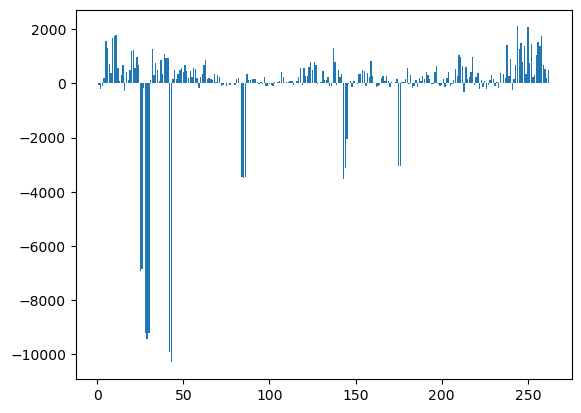

Upper Band SD: 1
Stop Gap Band: 10
Portfolio Return Rate: -0.010746285324089512
Sharpe Ratio: -0.05934483025135199


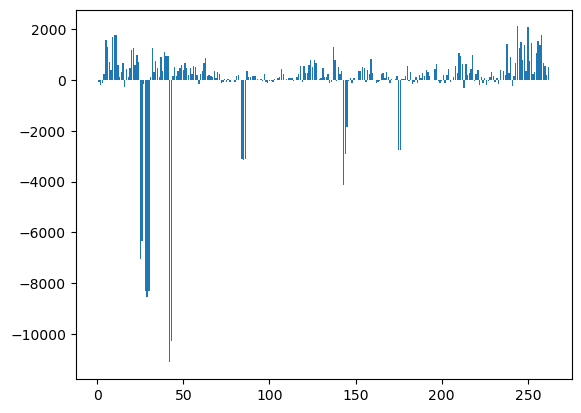

Upper Band SD: 1
Stop Gap Band: 9
Portfolio Return Rate: -0.004033393365187422
Sharpe Ratio: -0.052362189831808


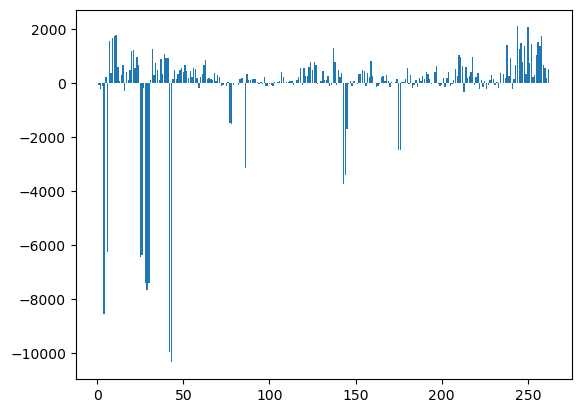

Upper Band SD: 1
Stop Gap Band: 8
Portfolio Return Rate: -0.021464993099090425
Sharpe Ratio: -0.0756756090907182


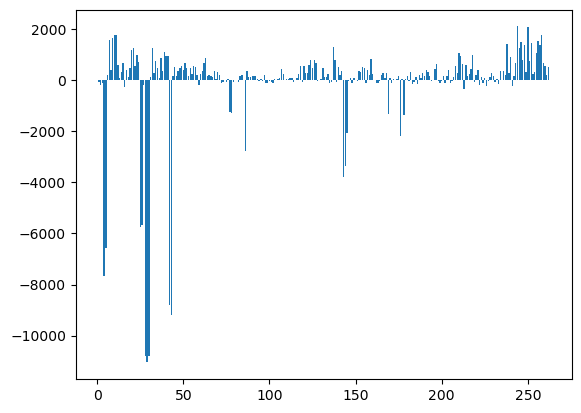

Upper Band SD: 1
Stop Gap Band: 7
Portfolio Return Rate: -0.03355539666517375
Sharpe Ratio: -0.086818524168749


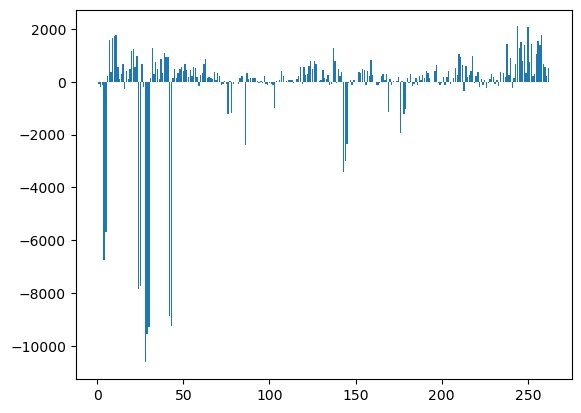

Upper Band SD: 1
Stop Gap Band: 6
Portfolio Return Rate: -0.03358872960146436
Sharpe Ratio: -0.08930874207769644
Max Sharpe: 0.084988232419241
Max Portfolio Return Rate: 0.26435928083335736


In [30]:
def backtest(upper_band_sd, stop_gap_band):
  open_positions = {}
  profit_log = []
  day = 10

  def PnL(executionPrice, price, fundingRate, current_day, days):
    total_fr = 3 * fundingRate * days
    entry_fee = btc_transaction_train_data['Fee'].iloc[current_day - days]
    exit_fee = btc_transaction_train_data['Fee'].iloc[current_day]
    profit_log.append(((price/20 + entry_fee + exit_fee + total_fr), (executionPrice - price) - total_fr - entry_fee - exit_fee))

#Main Backtest Logic
  for i in range(9, len(btc_price_train_data)):

    past10 = btc_price_train_data['open'].rolling(window=10)
    SMA10 = past10.mean()
    sd = past10.std()
    upper_band = SMA10 + upper_band_sd * sd
    lower_band = SMA10 - 0.25 * sd
    current_price = btc_price_train_data['open'].iloc[i]

    if (lower_band.iloc[i] <= current_price) & (current_price <= upper_band.iloc[i]):
      key = (lower_band.iloc[i], upper_band.iloc[i])
      if key not in open_positions:
        open_positions[key] = []
      open_positions[key].append((btc_price_train_data['open'][i], i))

    #Close the positions based on closing prices
    for key, positions in open_positions.items():
      lb, ub = key

      if btc_price_train_data['high'][i] >= ub:
        for position, day in positions:
          PnL(ub, position, daily_funding_rates_train_data['fundingRate'].iloc[day], i, i - day)
        open_positions[key] = [] #Clearing out all positions assosicated with this band (Neal)

      elif btc_price_train_data['low'][i] < lb - stop_gap_band * sd.iloc[i]:
        for position, day in positions:
          PnL(lb - stop_gap_band * sd.iloc[i], position, daily_funding_rates_train_data['fundingRate'].iloc[day], i, i - day)
        open_positions[key] = [] #Clearing out all positions assosicated with this band (Neal)


    def metrics(profit_log):
      """Calculate performance metrics"""
      if not profit_log:
        return 0, 0, 0

      list_risked = [profit[0] for profit in profit_log]
      list_returns = [profit[1] for profit in profit_log]
      list_of_return_rate = [profit[1]/profit[0] for profit in profit_log]

      mean_rate = sum(list_of_return_rate) / len(list_of_return_rate)
      total_risked = sum(list_risked)
      total_returns = sum(list_returns)
      portfolio_return_rate = total_returns / total_risked
      standardDev = np.std(list_of_return_rate)
      sharpe = (portfolio_return_rate - 0.04) / standardDev

      catergories = [i + 1 for i in range(len(list_returns))]
      plt.bar(catergories, list_returns)
      plt.show()

      return sharpe, mean_rate, standardDev, total_returns, portfolio_return_rate


  sharpe, mean_return, std_return, total_returns , portfolio_return_rate = metrics(profit_log)
  print(f"Upper Band SD: {upper_band_sd}")
  print(f"Stop Gap Band: {stop_gap_band}")
  print(f"Portfolio Return Rate: {portfolio_return_rate}")
  print(f"Sharpe Ratio: {sharpe}")
  return sharpe, portfolio_return_rate


max_sharpe = 0
max_portfolio_return_rate = 0

for upper in [5, 4, 3, 1]:
  for stop_gap in [10, 9, 8, 7, 6]:
    sharpe, portfolio_return_rate = backtest(upper, stop_gap)
    if sharpe > max_sharpe:
      max_sharpe = sharpe
    if portfolio_return_rate > max_portfolio_return_rate:
      max_portfolio_return_rate = portfolio_return_rate

print(f"Max Sharpe: {max_sharpe}")
print(f"Max Portfolio Return Rate: {max_portfolio_return_rate}")

## We see that 5, 8 for our band decisions work very well. So lets run it on my test data. 

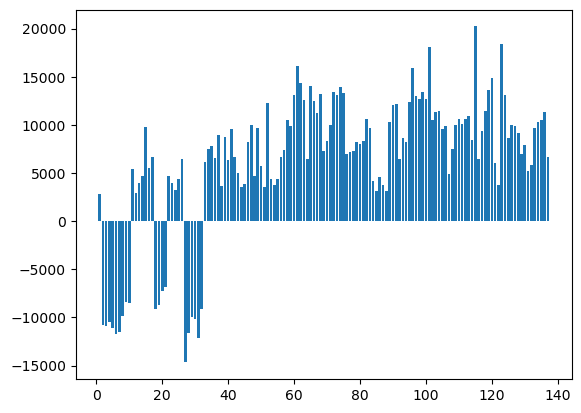

Sharpe Ratio: 0.7794500339768218
Mean Return: 1.798907588116973
Standard Deviation: 2.1798875278963363
Total Returns: 846581.7373322728
Portfolio Return Rate: 1.7391134076844494


In [33]:
open_positions = {}
profit_log = []
day = 10

def PnL(executionPrice, price, fundingRate, current_day, days):
  total_fr = 3 * fundingRate * days
  entry_fee = btc_transaction_test_data['Fee'].iloc[current_day - days]
  exit_fee = btc_transaction_test_data['Fee'].iloc[current_day]
  profit_log.append(((price/20 + entry_fee + exit_fee + total_fr), (executionPrice - price) - total_fr - entry_fee - exit_fee))

#Main Backtest Logic
for i in range(9, len(btc_price_test_data)):

  past10 = btc_price_test_data['open'].rolling(window=10)
  SMA10 = past10.mean()
  sd = past10.std()
  upper_band = SMA10 + 5 * sd
  lower_band = SMA10 - sd
  current_price = btc_price_test_data['open'].iloc[i]

  if (lower_band.iloc[i] <= current_price) & (current_price <= upper_band.iloc[i]):
    key = (lower_band.iloc[i], upper_band.iloc[i])
    if key not in open_positions:
      open_positions[key] = []
    open_positions[key].append((btc_price_test_data['open'][i], i))

  #Close the positions based on closing prices
  for key, positions in open_positions.items():
    lb, ub = key

    if btc_price_test_data['high'][i] >= ub:
      for position, day in positions:
        PnL(ub, position, daily_funding_rates_test_data['fundingRate'].iloc[day], i, i - day)
      open_positions[key] = [] #Clearing out all positions assosicated with this band (Neal)

    elif btc_price_test_data['low'][i] < lb - 8 * sd.iloc[i]:
      for position, day in positions:
        PnL(lb - 8 * sd.iloc[i], position, daily_funding_rates_test_data['fundingRate'].iloc[day], i, i - day)
      open_positions[key] = [] #Clearing out all positions assosicated with this band (Neal)


  def metrics(profit_log):
    """Calculate performance metrics"""
    if not profit_log:
      return 0, 0, 0

    list_risked = [profit[0] for profit in profit_log]
    list_returns = [profit[1] for profit in profit_log]
    list_of_return_rate = [profit[1]/profit[0] for profit in profit_log]

    mean_rate = sum(list_of_return_rate) / len(list_of_return_rate)
    total_risked = sum(list_risked)
    total_returns = sum(list_returns)
    portfolio_return_rate = total_returns / total_risked
    standardDev = np.std(list_of_return_rate)
    sharpe = (portfolio_return_rate - 0.04) / standardDev

    catergories = [i + 1 for i in range(len(list_returns))]
    plt.bar(catergories, list_returns)
    plt.show()

    return sharpe, mean_rate, standardDev, total_returns, portfolio_return_rate


sharpe, mean_return, std_return, total_returns , portfolio_return_rate = metrics(profit_log)
print(f"Sharpe Ratio: {sharpe}")
print(f"Mean Return: {mean_return}")
print(f"Standard Deviation: {std_return}")
print(f"Total Returns: {total_returns}")
print(f"Portfolio Return Rate: {portfolio_return_rate}")

### Great Results!!! But maybe its Trump election drove the results. Lets instead try splitting it between a biden and Trump version

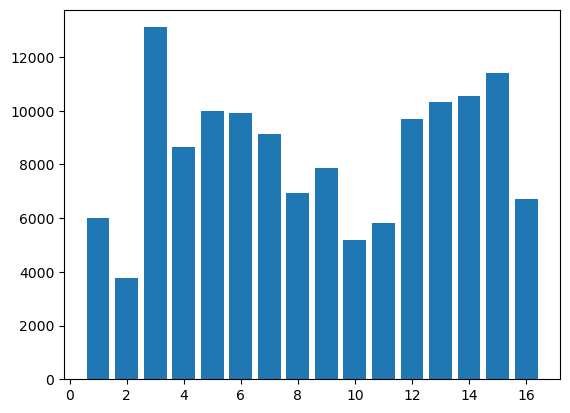

Sharpe Ratio: 3.10078179151117
Mean Return: 1.6549030385441632
Standard Deviation: 0.5170562655250496
Total Returns: 135026.21910418823
Portfolio Return Rate: 1.6432786533268384


In [36]:
open_positions = {}
profit_log = []
day = 10

def PnL(executionPrice, price, fundingRate, current_day, days):
  total_fr = 3 * fundingRate * days
  entry_fee = trump_btc_transaction_test_data['Fee'].iloc[current_day - days]
  exit_fee = trump_btc_transaction_test_data['Fee'].iloc[current_day]
  profit_log.append(((price/20 + entry_fee + exit_fee + total_fr), (executionPrice - price) - total_fr - entry_fee - exit_fee))

#Main Backtest Logic
for i in range(9, len(trump_btc_price_test_data)):

  past10 = trump_btc_price_test_data['open'].rolling(window=10)
  SMA10 = past10.mean()
  sd = past10.std()
  upper_band = SMA10 + 5 * sd
  lower_band = SMA10 - sd
  current_price = trump_btc_price_test_data['open'].iloc[i]

  if (lower_band.iloc[i] <= current_price) & (current_price <= upper_band.iloc[i]):
    key = (lower_band.iloc[i], upper_band.iloc[i])
    if key not in open_positions:
      open_positions[key] = []
    open_positions[key].append((trump_btc_price_test_data['open'].iloc[i], i))

  #Close the positions based on closing prices
  for key, positions in open_positions.items():
    lb, ub = key

    if trump_btc_price_test_data['high'].iloc[i] >= ub:
      for position, day in positions:
        PnL(ub, position, trump_daily_funding_rates_test_data['fundingRate'].iloc[day], i, i - day)
      open_positions[key] = [] #Clearing out all positions assosicated with this band (Neal)

    elif trump_btc_price_test_data['low'].iloc[i] < lb - 8 * sd.iloc[i]:
      for position, day in positions:
        PnL(lb - 8 * sd.iloc[i], position, trump_daily_funding_rates_test_data['fundingRate'].iloc[day], i, i - day)
      open_positions[key] = [] #Clearing out all positions assosicated with this band (Neal)


  def metrics(profit_log):
    """Calculate performance metrics"""
    if not profit_log:
      return 0, 0, 0

    list_risked = [profit[0] for profit in profit_log]
    list_returns = [profit[1] for profit in profit_log]
    list_of_return_rate = [profit[1]/profit[0] for profit in profit_log]

    mean_rate = sum(list_of_return_rate) / len(list_of_return_rate)
    total_risked = sum(list_risked)
    total_returns = sum(list_returns)
    portfolio_return_rate = total_returns / total_risked
    standardDev = np.std(list_of_return_rate)
    sharpe = (portfolio_return_rate - 0.04) / standardDev

    catergories = [i + 1 for i in range(len(list_returns))]
    plt.bar(catergories, list_returns)
    plt.show()

    return sharpe, mean_rate, standardDev, total_returns, portfolio_return_rate


sharpe, mean_return, std_return, total_returns , portfolio_return_rate = metrics(profit_log)
print(f"Sharpe Ratio: {sharpe}")
print(f"Mean Return: {mean_return}")
print(f"Standard Deviation: {std_return}")
print(f"Total Returns: {total_returns}")
print(f"Portfolio Return Rate: {portfolio_return_rate}")

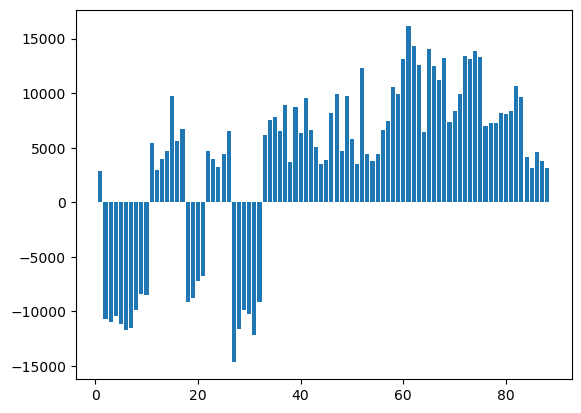

Sharpe Ratio: 0.4639913412367864
Mean Return: 1.2944257228135565
Standard Deviation: 2.4375555964983464
Total Returns: 335321.8822247847
Portfolio Return Rate: 1.1710046905585028


In [42]:
#Biden
open_positions = {}
profit_log = []
day = 10

def PnL(executionPrice, price, fundingRate, current_day, days):
  total_fr = 3 * fundingRate * days
  entry_fee = biden_btc_transaction_test_data['Fee'].iloc[current_day - days]
  exit_fee = biden_btc_transaction_test_data['Fee'].iloc[current_day]
  profit_log.append(((price/20 + entry_fee + exit_fee + total_fr), (executionPrice - price) - total_fr - entry_fee - exit_fee))

#Main Backtest Logic
for i in range(9, len(biden_btc_price_test_data)):

  past10 = biden_btc_price_test_data['open'].rolling(window=10)
  SMA10 = past10.mean()
  sd = past10.std()
  upper_band = SMA10 + 5 * sd
  lower_band = SMA10 - sd
  current_price = biden_btc_price_test_data['open'].iloc[i]

  if (lower_band.iloc[i] <= current_price) & (current_price <= upper_band.iloc[i]):
    key = (lower_band.iloc[i], upper_band.iloc[i])
    if key not in open_positions:
      open_positions[key] = []
    open_positions[key].append((biden_btc_price_test_data['open'].iloc[i], i))

  #Close the positions based on closing prices
  for key, positions in open_positions.items():
    lb, ub = key

    if biden_btc_price_test_data['high'].iloc[i] >= ub:
      for position, day in positions:
        PnL(ub, position, biden_daily_funding_rates_test_data['fundingRate'].iloc[day], i, i - day)
      open_positions[key] = [] #Clearing out all positions assosicated with this band (Neal)

    elif biden_btc_price_test_data['low'].iloc[i] < lb - 8 * sd.iloc[i]:
      for position, day in positions:
        PnL(lb - 8 * sd.iloc[i], position, biden_daily_funding_rates_test_data['fundingRate'].iloc[day], i, i - day)
      open_positions[key] = [] #Clearing out all positions assosicated with this band (Neal)


  def metrics(profit_log):
    """Calculate performance metrics"""
    if not profit_log:
      return 0, 0, 0

    list_risked = [profit[0] for profit in profit_log]
    list_returns = [profit[1] for profit in profit_log]
    list_of_return_rate = [profit[1]/profit[0] for profit in profit_log]

    mean_rate = sum(list_of_return_rate) / len(list_of_return_rate)
    total_risked = sum(list_risked)
    total_returns = sum(list_returns)
    portfolio_return_rate = total_returns / total_risked
    standardDev = np.std(list_of_return_rate)
    sharpe = (portfolio_return_rate - 0.04) / standardDev

    catergories = [i + 1 for i in range(len(list_returns))]
    plt.bar(catergories, list_returns)
    plt.show()

    return sharpe, mean_rate, standardDev, total_returns, portfolio_return_rate


sharpe, mean_return, std_return, total_returns , portfolio_return_rate = metrics(profit_log)
print(f"Sharpe Ratio: {sharpe}")
print(f"Mean Return: {mean_return}")
print(f"Standard Deviation: {std_return}")
print(f"Total Returns: {total_returns}")
print(f"Portfolio Return Rate: {portfolio_return_rate}")

### As we can tell, we generate amazing returns even without the Trump presidency. Between 2024-05-26 and 2024-11-04 before trump was elected, Bitcoin only rose 1%. We in that period made over 110%.